# Student: Aleksander Alan Prymek
# ID: 22263179

The examined group comprised kernels belonging to three different varieties of wheat: Kama, Rosa and Canadian, 70 elements each. 

To construct the data, seven geometric parameters of wheat kernels were measured:

1. area $A$,
2. perimeter $P$,
3. compactness $C=4\pi\cdot A/P^2$,
4. length of kernel,
5. width of kernel,
6. asymmetry coefficient,
7. length of kernel groove.

All of these parameters were real-valued continuous.

The dependent variable is the column `type`.

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn.cluster import KMeans
#from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

## EDA

In [2]:
df = pd.read_csv('./seeds.csv')
df.head()

area  perimeter  compactness  length of kernel  width of kernel  \
0  15.26      14.84       0.8710             5.763            3.312   
1  14.88      14.57       0.8811             5.554            3.333   
2  14.29      14.09       0.9050             5.291            3.337   
3  13.84      13.94       0.8955             5.324            3.379   
4  16.14      14.99       0.9034             5.658            3.562   

   asymmetry coefficient  length of kernel groove  type  
0                  2.221                    5.220     1  
1                  1.018                    4.956     1  
2                  2.699                    4.825     1  
3                  2.259                    4.805     1  
4                  1.355                    5.175     1

In [3]:
df.tail()

area  perimeter  compactness  length of kernel  width of kernel  \
205  12.19      13.20       0.8783             5.137            2.981   
206  11.23      12.88       0.8511             5.140            2.795   
207  13.20      13.66       0.8883             5.236            3.232   
208  11.84      13.21       0.8521             5.175            2.836   
209  12.30      13.34       0.8684             5.243            2.974   

     asymmetry coefficient  length of kernel groove  type  
205                  3.631                    4.870     3  
206                  4.325                    5.003     3  
207                  8.315                    5.056     3  
208                  3.598                    5.044     3  
209                  5.637                    5.063     3

In [4]:
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

Let's check for missing values - there are none.

In [5]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

Let's check the distribution of the data using box plots. Only the `compactness` and `asymmetry coefficient` columns have outliers; we will apply log transformation and `RobustScaler` to them and `StandardScaler` to the other predictors.

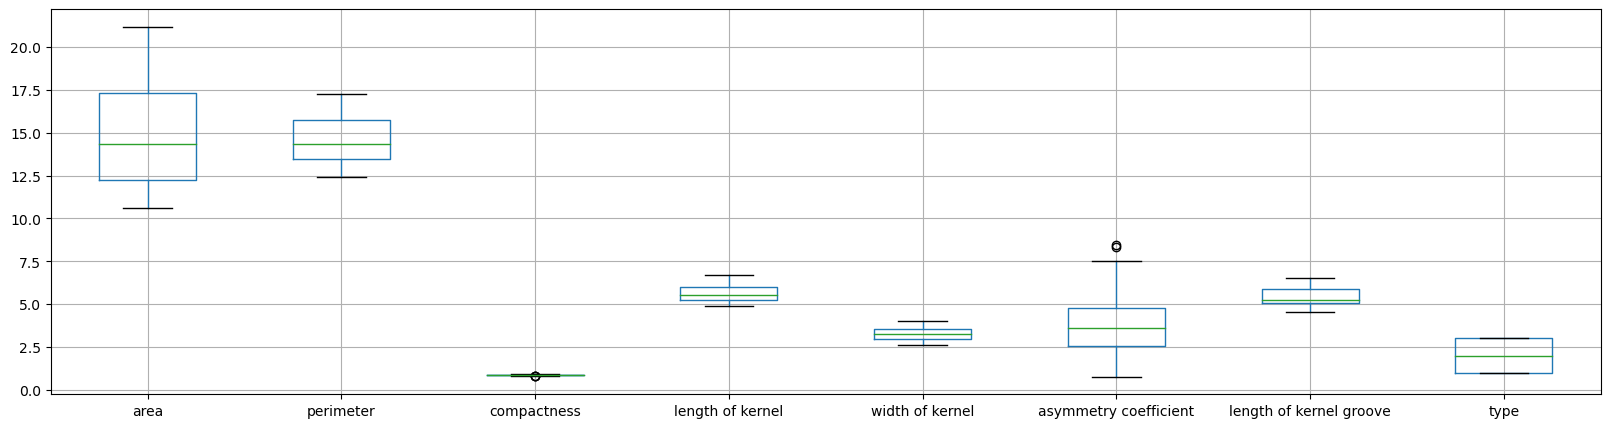

In [6]:
df.boxplot(figsize=(20,5))
plt.show()

## Data Preparation

In [7]:
names_all = [c for c in df if c not in ['type']]
names_outliers = ['compactness', 'asymmetry coefficient']
names_no_outliers = list(set(names_all) - set(names_outliers))

class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)
    
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

Since we are required to perform binary classification, we must reduce the target `type` column to two classes. We will do so using K-Means method with $k=2$.

In [8]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ('outlier_columns', make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ('no_outlier_columns', make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

In [9]:
df_kmeans = df.copy()
kmeans = KMeans(n_clusters=2, n_init=10, max_iter=300).fit(preprocess_pipeline.fit_transform(df_kmeans.loc[:, names_all]))

c:\Users\aleks\miniconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [10]:
old_types = df['type'].to_numpy()
new_types = kmeans.labels_
cls, cnts = np.unique(old_types[np.where(new_types == 0)[0]], return_counts=True)
cnts = map(str, cnts)
cls = map(str, cls)
print(f"New class 0 consists of {', '.join(cnts)} of old classes {', '.join(cls)}, respectively.")
cls, cnts = np.unique(old_types[np.where(new_types == 1)[0]], return_counts=True)
cnts = map(str, cnts)
cls = map(str, cls)
print(f"New class 1 consists of {', '.join(cnts)} of old classes {', '.join(cls)}, respectively.")

New class 0 consists of 8, 68 of old classes 1, 2, respectively.
New class 1 consists of 62, 2, 70 of old classes 1, 2, 3, respectively.


`KMeans` has mostly joined the `type`s `1` and `3` into a single class.

In [11]:
df['type'] = kmeans.labels_
df.head()

area  perimeter  compactness  length of kernel  width of kernel  \
0  15.26      14.84       0.8710             5.763            3.312   
1  14.88      14.57       0.8811             5.554            3.333   
2  14.29      14.09       0.9050             5.291            3.337   
3  13.84      13.94       0.8955             5.324            3.379   
4  16.14      14.99       0.9034             5.658            3.562   

   asymmetry coefficient  length of kernel groove  type  
0                  2.221                    5.220     1  
1                  1.018                    4.956     1  
2                  2.699                    4.825     1  
3                  2.259                    4.805     1  
4                  1.355                    5.175     0

Preprocess the data for the binary classification.

In [12]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

## Grid Search 

In [13]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])
param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) 
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.994:
Best parameters:  {'svm__C': 1, 'svm__gamma': 1, 'svm__kernel': 'linear'}


In [14]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])
param_grid = {
    'rf__n_estimators' : [10, 20, 30],
    'rf__max_depth': [2, 4, 6, 8]
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.988:
Best parameters:  {'rf__max_depth': 2, 'rf__n_estimators': 30}


## Compare Classifiers

In [15]:
mean_fpr = np.linspace(start=0, stop=1, num=100)
def evaluate_model(X_test, y_test, model):
    _probabilities = model.predict_proba(X_test)[:, 1]
    _predicted_values = model.predict(X_test)
    _accuracy = accuracy_score(y_test, _predicted_values)
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    _auc = auc(_fpr, _tpr)
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

def evaluate_model_average(N, X_test, y_test, model):
    accuracy, precision, recall, f1_score, tpr, auc = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    for _ in range(N):
        accuracy_temp, precision_temp, recall_temp, f1_score_temp, tpr_temp, auc_temp = evaluate_model(X_test, y_test, model)
        accuracy += accuracy_temp / N
        precision += precision_temp / N
        recall += recall_temp / N
        f1_score += f1_score_temp / N
        tpr += tpr_temp / N
        auc += auc_temp / N
    return accuracy, precision, recall, f1_score, tpr, auc

In [16]:
N = 100
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model_average(N, X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model_average(N, X_test, y_test, RF_best_model)

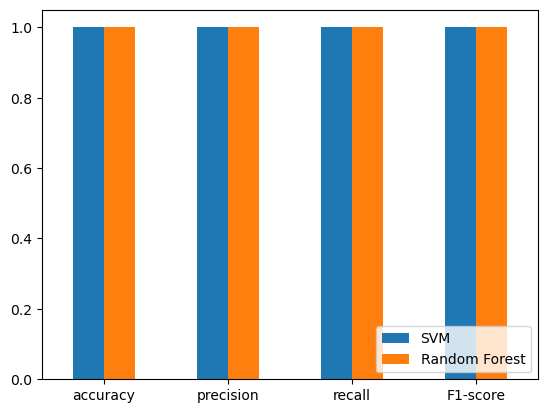

In [17]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

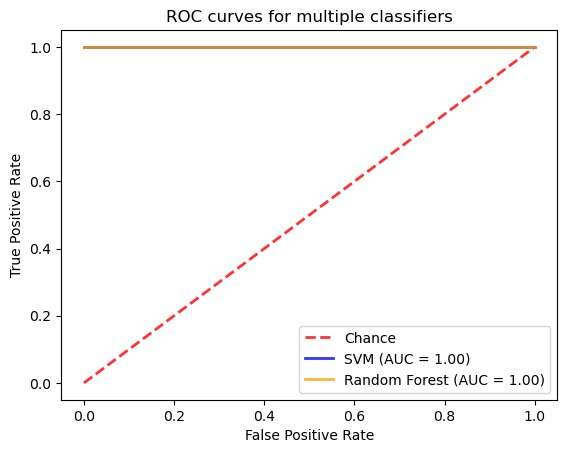

In [18]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

The models achieve almost identical performance and are able to nearly perfect delineate between the classes. Such amazing performance suggests that binary classification is too easy and the models should be able to relatively easily generalize to ternary classification. In general, SVM performs negligibly better. 

## Train a Final Model

In [19]:
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))
final_model = pipe.fit(X, y)
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

## Task 3 - kNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', KNeighborsClassifier())])
param_grid = {
    'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7],
    'knn__weights' : ['uniform', 'distance'],
    'knn__p': [1, 2, 3, 4],
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.982:
Best parameters:  {'knn__n_neighbors': 6, 'knn__p': 1, 'knn__weights': 'uniform'}


In [22]:
N = 100
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model_average(N, X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model_average(N, X_test, y_test, RF_best_model)
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model_average(N, X_test, y_test, KNN_best_model)

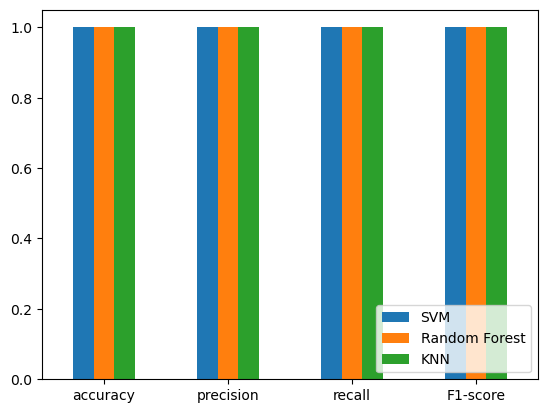

In [23]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'KNN': KNN_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

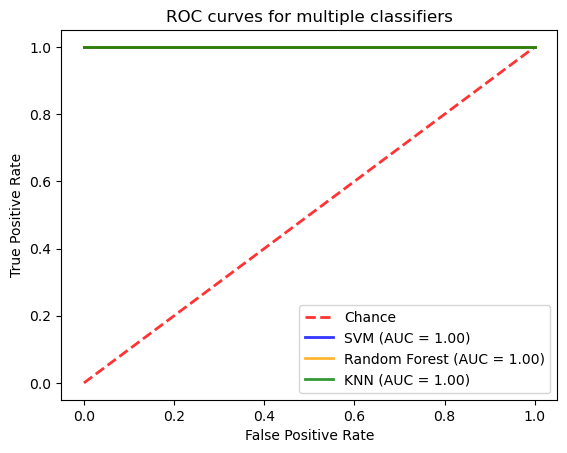

In [24]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, KNN_tpr[0,:], lw=2, color='green', label='KNN (AUC = %0.2f)' % (KNN_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

- How do SVM and Random Forest compare when trained with the seeds dataset?

    The models perform almost identically; often both models reach near perfect accuracy on the dataset with small differences in other metrics. Generally, SVM seems to perform negligibly better, however, any differences seem to stem from chance rather than inherent preference of one model over the other for this particular problem.

- Which additional probabilistic classifier have you used (or intend to use)? How does it compare to SVM and Random Forest?

    K-Nearest-Neighbors classifier was used. KNN, judging from the accuracy value, seem to perform slightly worse than SVM and comparably to Random Forest.

- Which parameters of the classifiers have you explored and what are the results?

    The following parameters were explored: `n_neighbors` (number of nearest neighbors to be found), `weights` (`distance` adds more relevance to the neighbors closer to the point), and `p`
    
    `algorithm` and `leaf_size` were not explored as they influence the efficiency of the computation, but should not affect the actual performance of the model.

    The best parameters were found to be: `{'knn__n_neighbors': 6, 'knn__p': 1, 'knn__weights': 'uniform'}` with accuracy of `0.982` (compared to `0.994` and `0.988` for SVM and RF, respectively).

- Do the ROC curves help in picking the best classifier in this case?

    No, as all models reach AUC of $1$. The only difference in performance is in $2$-nd or $3$-rd place after comma. 